## Classical Watermarking Approaches - Multimedia Project
### Daniele Materia

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

%matplotlib inline

# File paths
SUBSET_DIR = Path("images/test_subset")
test_images = sorted(list(SUBSET_DIR.glob("*.png")))
QUALITATIVE_EXAMPLE_INDEX = 14

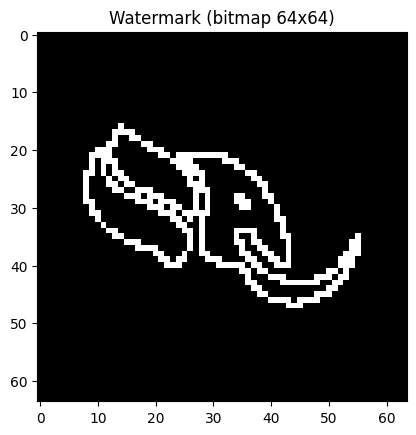

In [2]:
def create_binary_watermark(img_path, size):
    """
    Create a binary watermark image of shape (size, size) starting from an existing image.
    """
    watermark = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    watermark = cv2.resize(watermark, (size, size), interpolation=cv2.INTER_AREA)
    watermark = (watermark > 0).astype(np.uint8)
    return watermark

watermark = create_binary_watermark("./images/unict_pittogramma_320x320.png", size=64)
plt.imshow(watermark, cmap='gray')
plt.title("Watermark (bitmap 64x64)")
plt.show()

class WatermarkingAttacks:
    @staticmethod
    def jpeg_compression(image, quality):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        return cv2.imdecode(encimg, 1)

    @staticmethod
    def gaussian_blur(image, kernel_size=3, sigma=1):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

    @staticmethod
    def salt_and_pepper(image, amount=0.01):
        out = np.copy(image)
        # Salt noise
        num_salt = np.ceil(amount * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 255
        # Pepper noise
        num_pepper = np.ceil(amount * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        return out
    
def calculate_psnr(im1, im2):
    """Compute PSNR between two images."""
    mse = np.mean((im1-im2)**2)
    psnr = 100 if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

def calculate_ber(img1, img2):
    """Compute Bit Error Rate between two binary images, with respect to the first image."""
    return np.sum(img1 != img2) / img1.size

### 1. Discrete Cosine Transform Watermarking

In [3]:
def embed_dct_blocks_watermark(image, watermark, alpha):
    """
    Apply a Discrete Cosine Transform using 8x8 blocks and embed the watermark inside them
    """
    # convert the color space from RGB to YCrCb
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y_channel = img_yuv[:,:,0].astype(np.float32) / 255.0
    h, w = y_channel.shape
    
    # Flatten the watermark to enable its embedding in the blocks
    watermark_flat = watermark.flatten()
    block_idx = 0

    # Iteration over the 8x8 blocks
    for i in range(0, h - 7, 8):
        for j in range(0, w - 7, 8):
            if block_idx >= len(watermark_flat):
                break
                
            block = y_channel[i:i+8, j:j+8]
            dct_block = cv2.dct(block)
            
            # We choose to embed the watermark at the mean frequency coordinates (3,3)
            freq_coord = (3, 3)
            
            # Watermark embedding
            bit = watermark_flat[block_idx]
            if bit == 1:
                dct_block[freq_coord] += alpha
            else:
                dct_block[freq_coord] -= alpha

            # inverse DCT to insert back the new luminance value
            y_channel[i:i+8, j:j+8] = cv2.idct(dct_block)
                
            block_idx += 1

    img_yuv[:,:,0] = np.clip(y_channel * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2RGB)

def extract_dct_blocks_watermark(marked_img, original_img, watermark_shape):
    """
    Extract the watermark using the DCT coefficients.
    """
    y_marked = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YCrCb)[:,:,0].astype(np.float32) / 255.0
    y_orig = cv2.cvtColor(original_img, cv2.COLOR_RGB2YCrCb)[:,:,0].astype(np.float32) / 255.0
    
    extracted_watermark = []
    h, w = y_marked.shape
    
    for i in range(0, h - 7, 8):
        for j in range(0, w - 7, 8):            
            dct_m = cv2.dct(y_marked[i:i+8, j:j+8])
            dct_o = cv2.dct(y_orig[i:i+8, j:j+8])
            
            bit = 1 if dct_m[3,3] > dct_o[3,3] else 0
            extracted_watermark.append(bit)
            
    return np.array(extracted_watermark).reshape(watermark_shape)

#### Qualitative example of first classical approach (DCT), included attacks on watermark

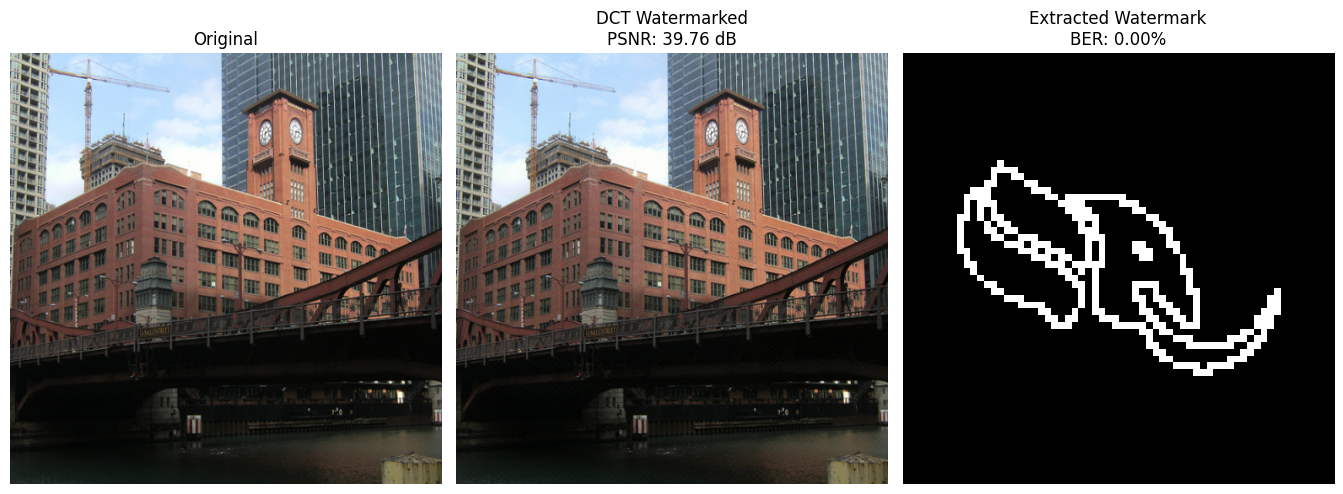

Attack to the watermark with JPEG compression


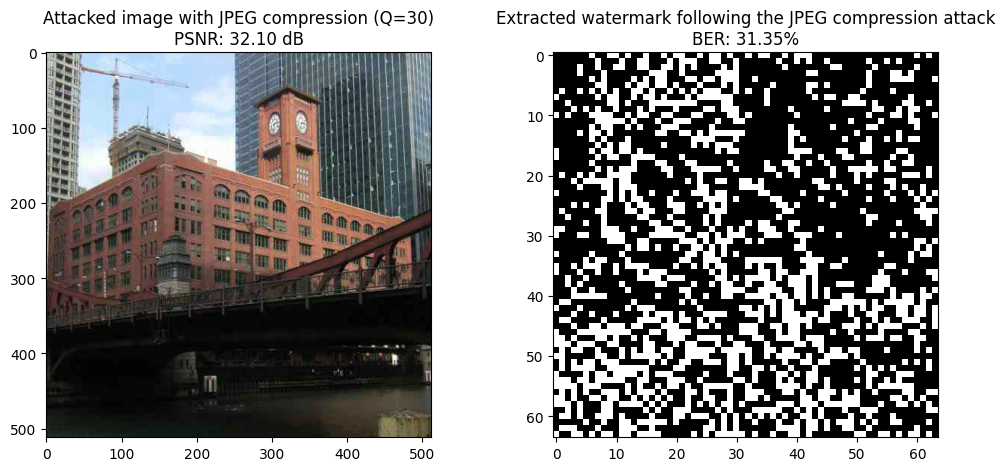

Attack to the watermark with Gaussian blur


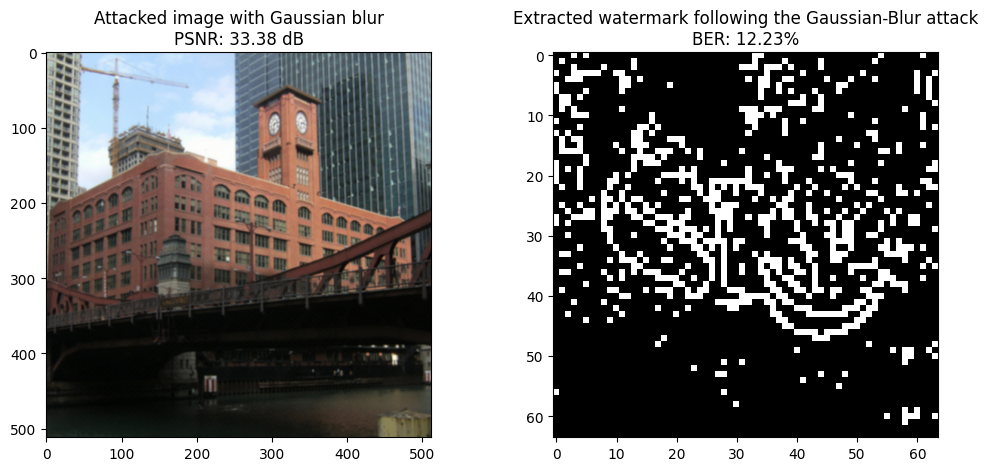

Attack to the watermark with Salt-Pepper noise


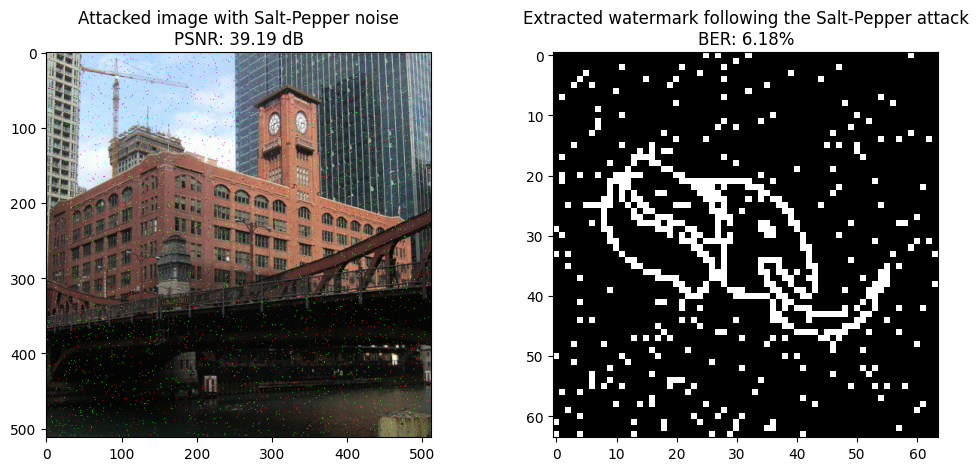

In [4]:
img_path = test_images[QUALITATIVE_EXAMPLE_INDEX]
img_bgr = cv2.imread(str(img_path))
img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Embedding and extraction
alpha_val = 0.08 # a low alpha value improves the watermark's invisibility
marked_image = embed_dct_blocks_watermark(img_orig, watermark, alpha=alpha_val)
extracted_watermark = extract_dct_blocks_watermark(marked_image, img_orig, watermark.shape)
# Compute metrics
ber = calculate_ber(watermark, extracted_watermark)
psnr = calculate_psnr(img_orig, marked_image)

plt.figure(figsize=(18, 6))
# Original
plt.subplot(141)
plt.title("Original")
plt.imshow(img_orig)
plt.axis('off')

# Watermarked
plt.subplot(142)
plt.title(f"DCT Watermarked\nPSNR: {psnr:.2f} dB")
plt.imshow(marked_image)
plt.axis('off')

# Extracted watermark
plt.subplot(143)
plt.title(f"Extracted Watermark\nBER: {ber:.2%}")
plt.imshow(extracted_watermark, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# JPEG attack
print("Attack to the watermark with JPEG compression")
attacked_image_jpeg = WatermarkingAttacks.jpeg_compression(marked_image, quality=30)
extracted_after_attack_jpeg = extract_dct_blocks_watermark(attacked_image_jpeg, img_orig, watermark.shape)
ber_attacked_jpeg = calculate_ber(watermark, extracted_after_attack_jpeg)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title(f"Attacked image with JPEG compression (Q=30)\nPSNR: {calculate_psnr(img_orig, attacked_image_jpeg):.2f} dB")
plt.imshow(attacked_image_jpeg)
plt.subplot(122)
plt.title(f"Extracted watermark following the JPEG compression attack\nBER: {ber_attacked_jpeg:.2%}")
plt.imshow(extracted_after_attack_jpeg, cmap='gray')
plt.show()

# Gaussian Blur attack
print("Attack to the watermark with Gaussian blur")
attacked_image_gaussian = WatermarkingAttacks.gaussian_blur(marked_image)
extracted_after_attack_gaussian = extract_dct_blocks_watermark(attacked_image_gaussian, img_orig, watermark.shape)
ber_attacked_gaussian = calculate_ber(watermark, extracted_after_attack_gaussian)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(f"Attacked image with Gaussian blur\nPSNR: {calculate_psnr(img_orig, attacked_image_gaussian):.2f} dB")
plt.imshow(attacked_image_gaussian)
plt.subplot(122)
plt.title(f"Extracted watermark following the Gaussian-Blur attack\nBER: {ber_attacked_gaussian:.2%}")
plt.imshow(extracted_after_attack_gaussian, cmap='gray')
plt.show()

# Salt-Pepper attack
print("Attack to the watermark with Salt-Pepper noise")
attacked_image_saltpepper = WatermarkingAttacks.salt_and_pepper(marked_image)
extracted_after_attack_saltpepper = extract_dct_blocks_watermark(attacked_image_saltpepper, img_orig, watermark.shape)
ber_attacked_saltpepper = calculate_ber(watermark, extracted_after_attack_saltpepper)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(f"Attacked image with Salt-Pepper noise\nPSNR: {calculate_psnr(img_orig, attacked_image_saltpepper):.2f} dB")
plt.imshow(attacked_image_saltpepper)
plt.subplot(122)
plt.title(f"Extracted watermark following the Salt-Pepper attack\nBER: {ber_attacked_saltpepper:.2%}")
plt.imshow(extracted_after_attack_saltpepper, cmap='gray')
plt.show()

#### Full experiments on test set of 200 random images from COCO2017 Val (with attacks on watermark)

In [5]:
results_list_dct = []
results_list_dct_attacked = [[], [], []] # DCT with attacks to watermark (0 -> jpeg, 1 -> gaussian-blur, 2 -> salt-pepper noise)
alpha_val = 0.08

for i, img_path in enumerate(test_images):
    img_bgr = cv2.imread(str(img_path))
    img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Embedding and extraction
    marked_image = embed_dct_blocks_watermark(img_orig, watermark, alpha=alpha_val)
    extracted_watermark = extract_dct_blocks_watermark(marked_image, img_orig, watermark.shape)

    # Compute evaluation metrics
    ber = calculate_ber(watermark, extracted_watermark)
    psnr = calculate_psnr(img_orig, marked_image)
    results_list_dct.append({
        "Image": img_path.name,
        "PSNR": psnr,
        "BER": ber
    })

    # Attacks to watermark
    # JPEG compression
    attacked_image = WatermarkingAttacks.jpeg_compression(marked_image, quality=30)
    extracted_after_attack = extract_dct_blocks_watermark(attacked_image, img_orig, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    results_list_dct_attacked[0].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

    # Gaussian Blur
    attacked_image = WatermarkingAttacks.gaussian_blur(marked_image)
    extracted_after_attack = extract_dct_blocks_watermark(attacked_image, img_orig, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    results_list_dct_attacked[1].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

    # Salt-Pepper Noise
    attacked_image = WatermarkingAttacks.salt_and_pepper(marked_image)
    extracted_after_attack = extract_dct_blocks_watermark(attacked_image, img_orig, watermark.shape)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    results_list_dct_attacked[2].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

# Create final DataFrames and save .csv files
df_dct = pd.DataFrame(results_list_dct)
df_dct.to_csv("./results/dct_results.csv", index=False)

df_dct_jpeg = pd.DataFrame(results_list_dct_attacked[0])
df_dct_jpeg.to_csv("./results/dct_jpeg_attack_results.csv")

df_dct_gaussian = pd.DataFrame(results_list_dct_attacked[1])
df_dct_gaussian.to_csv("./results/dct_gaussian_attack_results.csv")

df_dct_saltpepper = pd.DataFrame(results_list_dct_attacked[2])
df_dct_saltpepper.to_csv("./results/dct_saltpepper_attack_results.csv")

print("DCT statistics")
summary_stats_no_attacks = df_dct[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_jpeg = df_dct_jpeg[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_gaussian = df_dct_gaussian[['PSNR','BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_saltpepper = df_dct_saltpepper[['PSNR','BER']].agg(['mean', 'std', 'min', 'max'])
print("No attacks")
display(summary_stats_no_attacks)
print("JPEG compression attack")
display(summary_stats_jpeg)
print("Gaussian Blur attack")
display(summary_stats_gaussian)
print("Salt-Pepper noise")
display(summary_stats_saltpepper)

DCT statistics
No attacks


PSNR  BER
mean  39.824278  0.0
std    0.154396  0.0
min   39.681712  0.0
max   40.791844  0.0

JPEG compression attack


PSNR       BER
mean  33.002598  0.317178
std    1.538095  0.081657
min   29.758733  0.104492
max   37.621619  0.480225

Gaussian Blur attack


PSNR       BER
mean  35.456389  0.117158
std    2.530221  0.072613
min   30.152494  0.001709
max   42.494769  0.356201

Salt-Pepper noise


PSNR       BER
mean  39.239798  0.053206
std    0.169587  0.008628
min   39.067409  0.037354
max   40.280756  0.095703

### 2. Discrete Wavelet Transform + Singular Value Decomposition

In [6]:
import pywt

def embed_dwt_svd_blocks_watermark(image, watermark, alpha):
    """
    LL sub-band (256x256) divided into 4x4 blocks.
    Total blocks: (256/4) x (256/4) = 64 x 64 = 4096 blocks.
    Each block embeds 1 bit using SVD.
    Watermark capacity: 4096 bits (64x64 pixels).
    """
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    y_channel = img_yuv[:,:,0].astype(np.float32) / 255.0
    
    # DWT (Haar) -> LL is 256x256
    coeffs = pywt.dwt2(y_channel, 'haar')
    LL, (LH, HL, HH) = coeffs
    
    h_ll, w_ll = LL.shape
    watermark_flat = watermark.flatten()
    block_size = 4  # 256 / 4 = 64 blocks
    idx = 0
    LL_marked = LL.copy()
    
    # Iterate over the blocks of LL
    for i in range(0, h_ll, block_size):
        for j in range(0, w_ll, block_size):
            if idx >= len(watermark_flat): break
            
            block = LL[i:i+block_size, j:j+block_size]
            u, s, v = np.linalg.svd(block)
            
            # Embed the bit in the first singular value 
            bit = watermark_flat[idx]
            if bit == 1:
                s[0] += alpha
            else:
                s[0] -= alpha
                
            # Block reconstruction
            S = np.zeros_like(block)
            np.fill_diagonal(S, s)
            LL_marked[i:i+block_size, j:j+block_size] = u @ S @ v # @ is matrix multiplication
            idx += 1
            
    # inverse DWL and image reconstruction
    y_marked = pywt.idwt2((LL_marked, (LH, HL, HH)), 'haar')
    img_yuv[:,:,0] = np.clip(y_marked * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2RGB)

def extract_dwt_svd_blocks_watermark(marked_img, original_img, watermark_shape):
    """
    DWT-SVD watermark extraction.
    """
    y_m = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YCrCb)[:,:,0].astype(np.float32) / 255.0
    y_o = cv2.cvtColor(original_img, cv2.COLOR_RGB2YCrCb)[:,:,0].astype(np.float32) / 255.0
    
    LL_m, _ = pywt.dwt2(y_m, 'haar')
    LL_o, _ = pywt.dwt2(y_o, 'haar')
    
    h_ll, w_ll = LL_m.shape
    block_size = 4
    extracted_bits = []
    
    for i in range(0, h_ll, block_size):
        for j in range(0, w_ll, block_size):
            if len(extracted_bits) >= watermark_shape[0] * watermark_shape[1]: break
            
            _, s_m, _ = np.linalg.svd(LL_m[i:i+block_size, j:j+block_size])
            _, s_o, _ = np.linalg.svd(LL_o[i:i+block_size, j:j+block_size])
            
            bit = 1 if s_m[0] > s_o[0] else 0
            extracted_bits.append(bit)
            
    return np.array(extracted_bits).reshape(watermark_shape).astype(np.uint8)

#### Qualitative example of second classical approach (DWT-SVD)

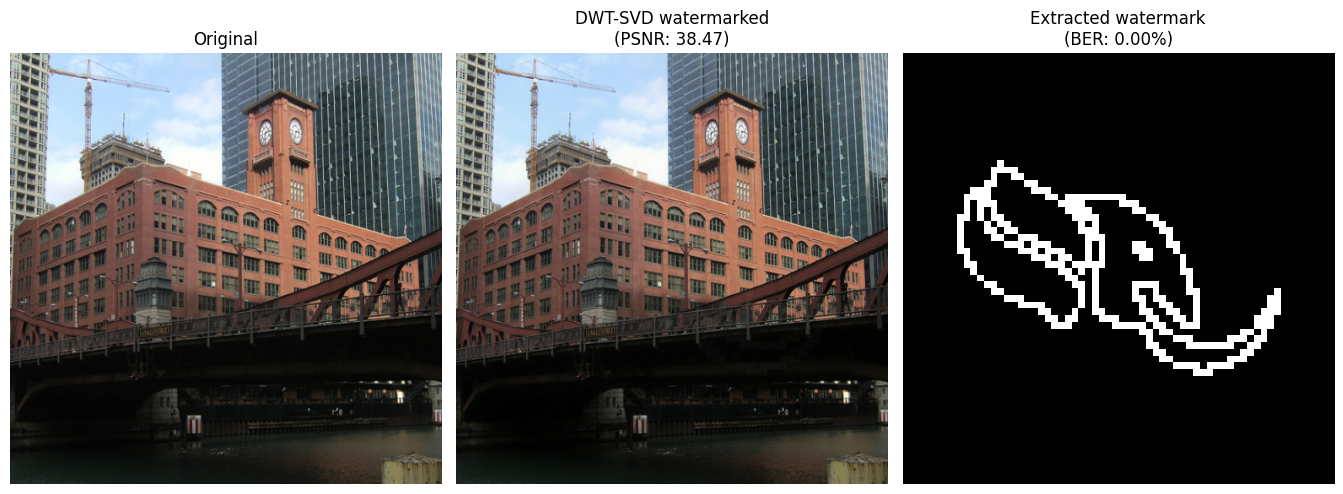

Attack to the watermark with JPEG compression


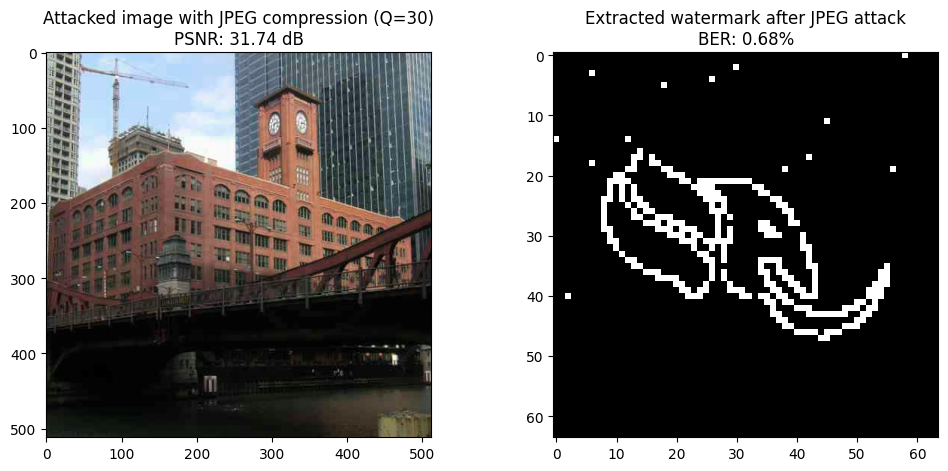

Attack to the watermark with Gaussian blur


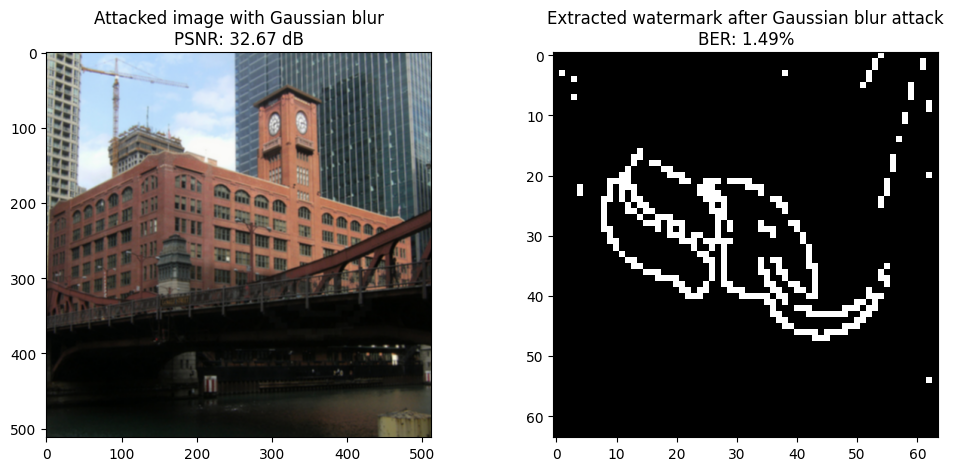

Attack to the watermark with Salt-Pepper noise


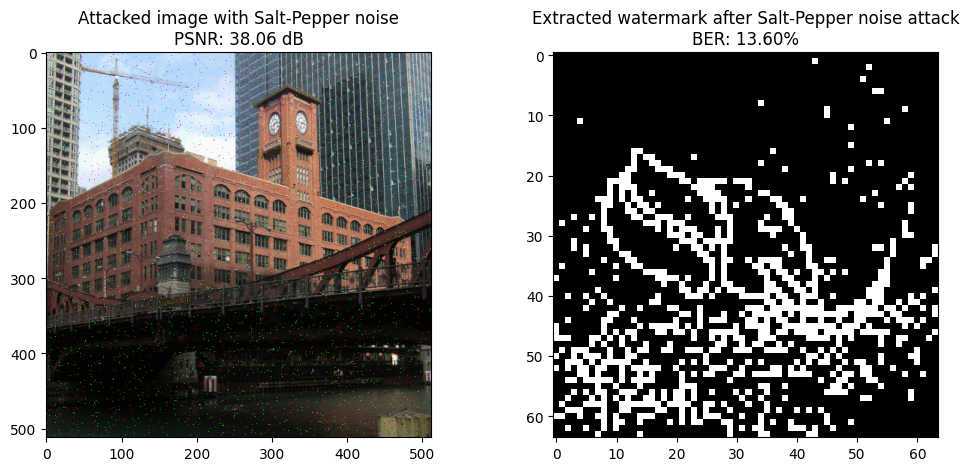

In [7]:
img_bgr = cv2.imread(str(test_images[QUALITATIVE_EXAMPLE_INDEX]))
img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Embedding and extraction
alpha_val_dwt = 0.08
marked_dwt = embed_dwt_svd_blocks_watermark(img_orig, watermark, alpha=alpha_val_dwt)
extracted_watermark_dwt = extract_dwt_svd_blocks_watermark(marked_dwt, img_orig, watermark.shape)

# Compute metrics
ber_dwt = calculate_ber(watermark, extracted_watermark_dwt)
psnr_dwt = calculate_psnr(img_orig, marked_dwt)

# Original
plt.figure(figsize=(18, 6))
plt.subplot(141)
plt.title("Original")
plt.imshow(img_orig)
plt.axis('off')

# Watermarked
plt.subplot(142)
plt.title(f"DWT-SVD watermarked\n(PSNR: {psnr_dwt:.2f})") 
plt.imshow(marked_dwt)
plt.axis('off')

# Extracted watermark
plt.subplot(143)
plt.title(f"Extracted watermark\n(BER: {ber_dwt:.2%})") 
plt.imshow(extracted_watermark_dwt, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# JPEG compression attack
print("Attack to the watermark with JPEG compression")
attacked_image_jpeg = WatermarkingAttacks.jpeg_compression(marked_dwt, quality=30)
extracted_after_attack_jpeg = extract_dwt_svd_blocks_watermark(attacked_image_jpeg, img_orig, watermark.shape)
ber_attacked_jpeg = calculate_ber(watermark, extracted_after_attack_jpeg)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title(f"Attacked image with JPEG compression (Q=30)\nPSNR: {calculate_psnr(img_orig, attacked_image_jpeg):.2f} dB")
plt.imshow(attacked_image_jpeg)
plt.subplot(122)
plt.title(f"Extracted watermark after JPEG attack\nBER: {ber_attacked_jpeg:.2%}")
plt.imshow(extracted_after_attack_jpeg, cmap='gray')
plt.show()

# Gaussian Blur attack
print("Attack to the watermark with Gaussian blur")
attacked_image_gaussian = WatermarkingAttacks.gaussian_blur(marked_dwt)
extracted_after_attack_gaussian = extract_dwt_svd_blocks_watermark(attacked_image_gaussian, img_orig, watermark.shape)
ber_attacked_gaussian = calculate_ber(watermark, extracted_after_attack_gaussian)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(f"Attacked image with Gaussian blur\nPSNR: {calculate_psnr(img_orig, attacked_image_gaussian):.2f} dB")
plt.imshow(attacked_image_gaussian)
plt.subplot(122)
plt.title(f"Extracted watermark after Gaussian blur attack\nBER: {ber_attacked_gaussian:.2%}")
plt.imshow(extracted_after_attack_gaussian, cmap='gray')
plt.show()

# Salt-Pepper attack
print("Attack to the watermark with Salt-Pepper noise")
attacked_image_saltpepper = WatermarkingAttacks.salt_and_pepper(marked_dwt)
extracted_after_attack_saltpepper = extract_dwt_svd_blocks_watermark(attacked_image_saltpepper, img_orig, watermark.shape)
ber_attacked_saltpepper = calculate_ber(watermark, extracted_after_attack_saltpepper)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(f"Attacked image with Salt-Pepper noise\nPSNR: {calculate_psnr(img_orig, attacked_image_saltpepper):.2f} dB")
plt.imshow(attacked_image_saltpepper)
plt.subplot(122)
plt.title(f"Extracted watermark after Salt-Pepper noise attack\nBER: {ber_attacked_saltpepper:.2%}")
plt.imshow(extracted_after_attack_saltpepper, cmap='gray')
plt.show()

#### Full experiments on test set of 200 random images from COCO2017 Val

In [8]:
results_list_dwt = []
results_list_dwt_attacked = [[], [], []] # DWT with attacks to watermark (0 -> jpeg, 1 -> gaussian-blur, 2 -> salt-pepper noise)

for i, img_path in enumerate(test_images):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None: continue
    img_orig = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Embedding and extraction
    marked_image_dwt = embed_dwt_svd_blocks_watermark(img_orig, watermark, alpha=alpha_val_dwt)
    extracted_watermark_dwt = extract_dwt_svd_blocks_watermark(marked_image_dwt, img_orig, watermark.shape)

    # Compute metrics
    ber = np.sum(watermark != extracted_watermark_dwt) / watermark.size
    psnr = calculate_psnr(img_orig, marked_image_dwt)
    
    results_list_dwt.append({
        "Image": img_path.name,
        "PSNR": psnr,
        "BER": ber
    })

    # Attacks to watermark
    # JPEG compression
    attacked_image = WatermarkingAttacks.jpeg_compression(marked_image_dwt, quality=30)
    extracted_after_attack = extract_dwt_svd_blocks_watermark(attacked_image, img_orig, watermark.shape)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    results_list_dwt_attacked[0].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

    # Gaussian Blur
    attacked_image = WatermarkingAttacks.gaussian_blur(marked_image_dwt)
    extracted_after_attack = extract_dwt_svd_blocks_watermark(attacked_image, img_orig, watermark.shape)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    results_list_dwt_attacked[1].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

    # Salt-Pepper Noise
    attacked_image = WatermarkingAttacks.salt_and_pepper(marked_image_dwt)
    extracted_after_attack = extract_dwt_svd_blocks_watermark(attacked_image, img_orig, watermark.shape)
    ber_attacked = calculate_ber(watermark, extracted_after_attack)
    psnr_attacked = calculate_psnr(img_orig, attacked_image)
    results_list_dwt_attacked[2].append({
        "Image": img_path.name,
        "PSNR": psnr_attacked,
        "BER": ber_attacked
    })

# Create DataFrames and save .csv files
df_dwt = pd.DataFrame(results_list_dwt)
df_dwt.to_csv("./results/dwt_results.csv", index=False)

df_dwt_jpeg = pd.DataFrame(results_list_dwt_attacked[0])
df_dwt_jpeg.to_csv("./results/dwt_jpeg_attack_results.csv")

df_dwt_gaussian = pd.DataFrame(results_list_dwt_attacked[1])
df_dwt_gaussian.to_csv("./results/dwt_gaussian_attack_results.csv")

df_dwt_saltpepper = pd.DataFrame(results_list_dwt_attacked[2])
df_dwt_saltpepper.to_csv("./results/dwt_saltpepper_attack_results.csv")

print("DWT-SVD statistics")
summary_stats_no_attacks = df_dwt[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_jpeg = df_dwt_jpeg[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_gaussian = df_dwt_gaussian[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
summary_stats_saltpepper = df_dwt_saltpepper[['PSNR', 'BER']].agg(['mean', 'std', 'min', 'max'])
print("No attacks")
display(summary_stats_no_attacks)
print("JPEG compression attack")
display(summary_stats_jpeg)
print("Gaussian Blur attack")
display(summary_stats_gaussian)
print("Salt-Pepper noise")
display(summary_stats_saltpepper)

DWT-SVD statistics
No attacks


PSNR       BER
mean  38.628613  0.000040
std    0.184712  0.000422
min   38.445547  0.000000
max   39.942162  0.005859

JPEG compression attack


PSNR       BER
mean  32.482320  0.009276
std    1.178107  0.007019
min   29.761850  0.000000
max   35.606567  0.048096

Gaussian Blur attack


PSNR       BER
mean  33.997195  0.009717
std    1.647276  0.008782
min   29.980842  0.000000
max   37.565205  0.046387

Salt-Pepper noise


PSNR       BER
mean  38.186470  0.071686
std    0.188448  0.044856
min   38.002037  0.014893
max   39.531145  0.260986